In [192]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pgeocode

nomi = pgeocode.Nominatim("US")

plt.rcParams['figure.facecolor'] = 'white'
pd.set_option('display.max_rows', 1000)

In [193]:
huliaina = gpd.read_file("./huliaina (2).zip")
owners = pd.read_csv("./kauai_county_owners.csv")
sales = pd.read_csv("./kauai_county_sales_reformatted.csv")

In [194]:
kauai = gpd.read_file("Parcels_-_Kauai (1).zip")
usa = gpd.read_file("./cb_2018_us_state_500k.zip")

In [195]:
# cleanup
sales = sales.rename(columns={"Tax  Class ": "tax_class", "Year  Built ": "year_built", "Square Ft ": "square_ft"})
sales["Sale Price"] = sales["Sale Price"].replace({0: np.nan})
sales["Sale Date"] = pd.to_datetime(sales["Sale Date"])
sales = sales.drop_duplicates()

In [196]:
# merge parcel id to shapefile
sales_shp = kauai[["parid", "geometry"]].merge(sales.rename(columns={"Parcel ID": "parid"}), on="parid")
sales_shp = sales_shp.cx[:, 22.14:]  # grab just the north shore

/Users/dklink/opt/miniconda3/envs/kauai/lib/python3.10/site-packages/pandas/core/reshape/merge.py:1204: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  warnings.warn(


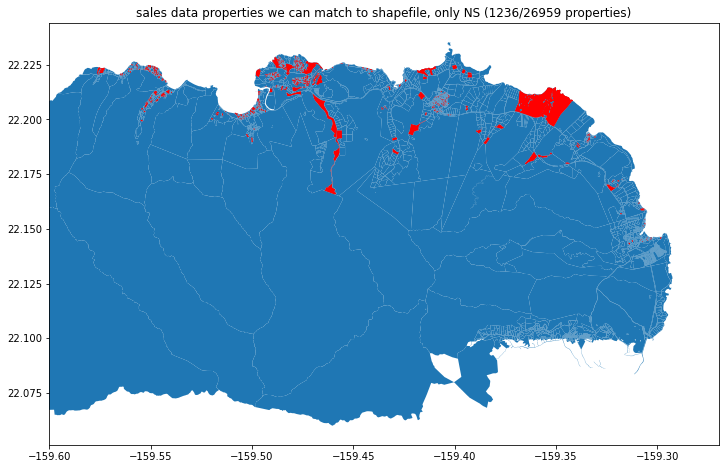

In [197]:
# plot where we're looking at
fig, ax = plt.subplots(figsize=(12, 8))
kauai.cx[:, 22.10:].plot(ax=ax)
sales_shp.plot(ax=ax, color="r")
plt.title(f"sales data properties we can match to shapefile, only NS ({len(sales_shp)}/{len(sales)} properties)")
ax.set_xlim([-159.6, None])
plt.savefig("brainstorming_figs/sales_merged_to_shapefile.png", dpi=150)

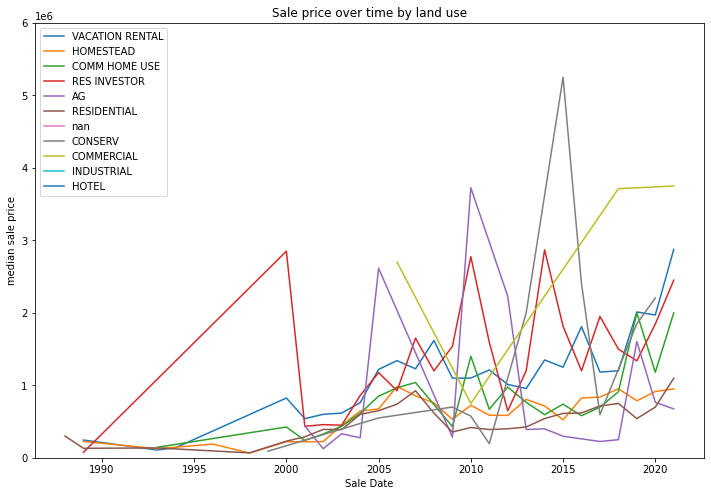

In [198]:
plt.figure(figsize=(12, 8))
for tclass in sales_shp["tax_class"].unique():
    data = sales_shp[sales_shp["tax_class"] == tclass].groupby(sales_shp["Sale Date"].dt.year).median()["Sale Price"]
    data.plot(label=tclass)
plt.legend(loc="upper left")
plt.ylabel("median sale price")
plt.title("Sale price over time by land use")
plt.ylim([0, .6e7])
plt.savefig("brainstorming_figs/sale_price_land_use.png", dpi=150)

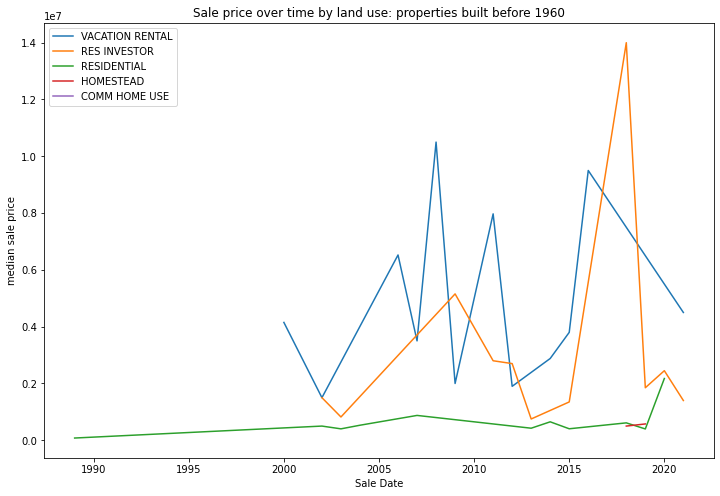

In [199]:
plt.figure(figsize=(12, 8))
year_thresh = 1960
old_homes = sales_shp[sales_shp["year_built"] < year_thresh]
for tclass in old_homes["tax_class"].unique():
    data = old_homes[old_homes["tax_class"] == tclass].groupby(old_homes["Sale Date"].dt.year).median()["Sale Price"]
    data.plot(label=tclass)
plt.legend(loc="upper left")
plt.ylabel("median sale price")
plt.title(f"Sale price over time by land use: properties built before {year_thresh}")
#plt.ylim([0, .6e7])
plt.savefig("brainstorming_figs/sale_price_old_properties.png", dpi=150)

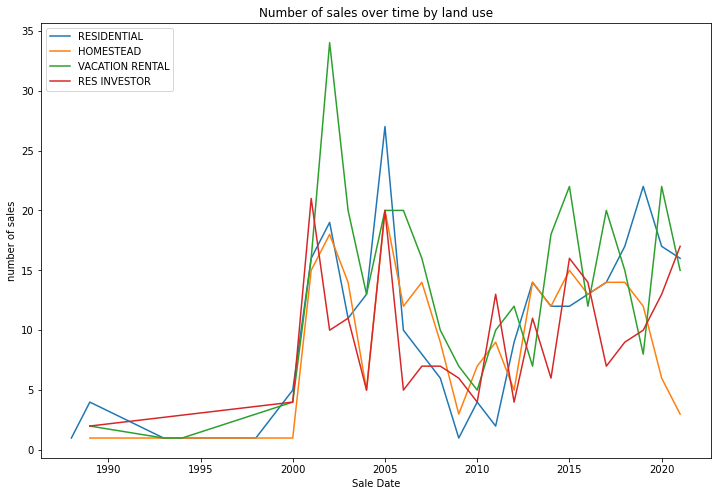

In [208]:
plt.figure(figsize=(12, 8))
for tclass in ["RESIDENTIAL", "HOMESTEAD", "VACATION RENTAL", "RES INVESTOR"]:
    data = sales_shp[sales_shp["tax_class"] == tclass].groupby(sales_shp["Sale Date"].dt.year).size()
    data.plot(label=tclass)
plt.legend(loc="upper left")
plt.ylabel("number of sales")
plt.title("Number of sales over time by land use")
plt.savefig("brainstorming_figs/num_sales_per_year.png", dpi=150)

# Airline Map

In [56]:
NS_ZIP_CODES = [96722, 96754, 96746] # last one is more like Ko'olau
NS_owners = owners[owners.Zip.isin(NS_ZIP_CODES)].dropna(subset=["Zip", "OwnerZip"])
NS_owners["OwnerZip"] = NS_owners["OwnerZip"].astype(int)
NS_owners["Zip"] = NS_owners["Zip"].astype(int)

In [120]:
percent_same_zip = NS_owners.OwnerZip.isin(NS_ZIP_CODES).sum() / len(NS_owners)
print(f"{percent_same_zip: .1%} of properties have a mailing address within the north shore")

 68.1% of properties have a mailing address within the north shore


In [149]:
out_owners = NS_owners[~NS_owners.OwnerZip.isin(NS_ZIP_CODES)]
owner_zips = pd.DataFrame(out_owners.groupby("OwnerZip").size(), columns=["num_owners"]).reset_index()

In [151]:
NS_lon = -159.484076
NS_lat = 22.220735
owner_zips[["latitude", "longitude"]] = nomi.query_postal_code(owner_zips.OwnerZip.astype(str).values)[["latitude", "longitude"]]
owner_zips = owner_zips.dropna()

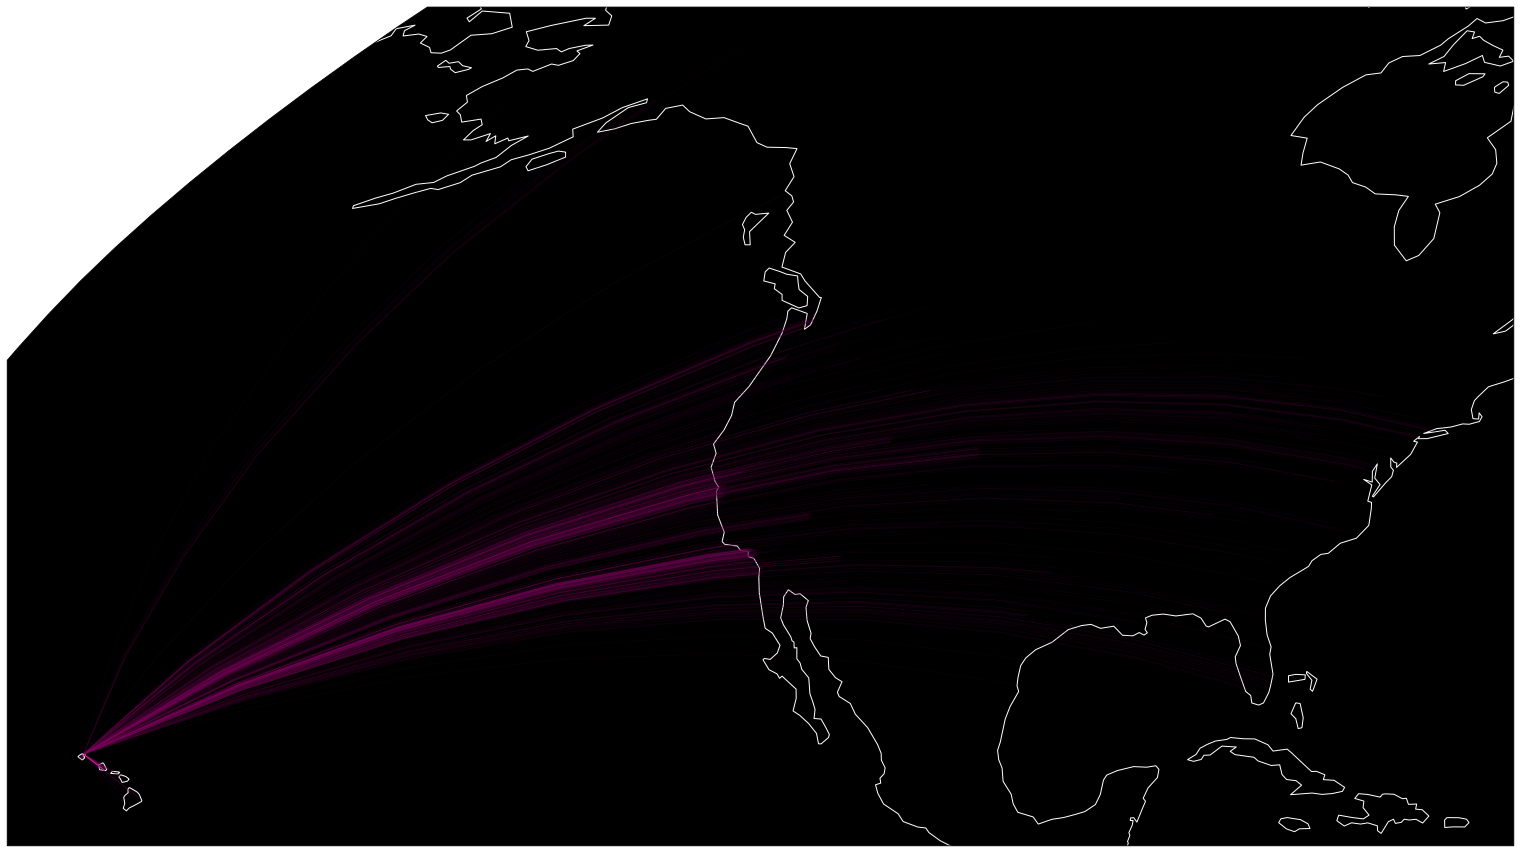

In [189]:
from matplotlib.colors import Normalize, LinearSegmentedColormap, PowerNorm

bg_color = (0.0, 0.0, 0, 1.0)
coast_color = (204/255.0, 0, 153/255.0, 0.7)
color_list = [(0.0, 0.0, 0.0, 0.0),
              (204/255.0, 0, 153/255.0, 0.6),
              (255/255.0, 204/255.0, 230/255.0, 1.0)]

# define the expected CSV columns
CSV_COLS = ('dep_lat', 'dep_lon', 'arr_lat', 'arr_lon',
            'nb_flights', 'CO2')

num_properties = len(owner_zips)

# normalize the dataset for color scale
norm = PowerNorm(0.3, 0, out_owners.groupby("OwnerZip").size().max())
#norm = Normalize(0, 
                 #out_owners.groupby("OwnerZip").size().max())

# create a linear color scale with enough colors
n = owner_zips["num_owners"].max()
cmap = LinearSegmentedColormap.from_list('cmap_flights', color_list, N=n)

# create the map and draw country boundaries
fig = plt.figure(figsize=(27, 20))
ax = plt.axes(projection=ccrs.Robinson())
ax.set_facecolor(bg_color)
ax.coastlines(color="white")

# plot each route with its color depending on the number of flights
for i, (idx, row) in enumerate(owner_zips.sort_values(by='num_owners', ascending=True).iterrows()):
    color = cmap(norm(int(row["num_owners"])))

    line = ax.plot([NS_lon, row["longitude"]],
                   [NS_lat, row['latitude']],
                      linewidth=.5, color=color, transform=ccrs.Geodetic())

fig.savefig("./brainstorming_figs/ownership_map.png", dpi=150)